# Feature Categorization using Satellite Imagery and Deep Learning
> * 🔬 Data Science
* 🥠 Deep Learning and Feature Classifier

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction and methodology" data-toc-modified-id="Introduction and methodology-1">Introduction and methodology</a></span></li><li><span><a href="#Part-1---Export-training-data-for-deep-learning" data-toc-modified-id="Part-1---Export-training-data-for-deep-learning-2">Part 1 - Export training data for deep learning</a></span><ul class="toc-item"><li><span><a href="#Import-ArcGIS-API-for-Python-and-get-connected-to-your-GIS" data-toc-modified-id="Import-ArcGIS-API-for-Python-and-get-connected-to-your-GIS-2.1">Import ArcGIS API for Python and get connected to your GIS</a></span></li><li><span><a href="#Prepare-data-that-will-be-used-for-training-data-export" data-toc-modified-id="Prepare-data-that-will-be-used-for-training-data-export-2.2">Prepare data that will be used for training data export</a></span></li><li><span><a href="#Specify-a-folder-name-in-raster-store-that-will-be-used-to-store-our-training-data" data-toc-modified-id="Specify-a-folder-name-in-raster-store-that-will-be-used-to-store-our-training-data-2.3">Specify a folder name in raster store that will be used to store our training data</a></span></li><li><span><a href="#Export-training-data-using-arcgis.learn" data-toc-modified-id="Export-training-data-using-arcgis.learn-2.4">Export training data using <code>arcgis.learn</code></a></span></li></ul></li><li><span><a href="#Part-2---Model-training" data-toc-modified-id="Part-2---Model-training-3">Part 2 - Model training</a></span><ul class="toc-item"><li><span><a href="#Visualize-training-data" data-toc-modified-id="Visualize-training-data-3.1">Visualize training data</a></span></li><li><span><a href="#Load-model-architecture" data-toc-modified-id="Load-model-architecture-3.2">Load model architecture</a></span></li><li><span><a href="#Train-a-model-through-learning-rate-tuning-and-transfer-learning" data-toc-modified-id="Train-a-model-through-learning-rate-tuning-and-transfer-learning-3.3">Train a model through learning rate tuning and transfer learning</a></span></li><li><span><a href="#Visualize-classification-results-in-validation-set" data-toc-modified-id="Visualize-classification-results-in-validation-set-3.4">Visualize classification results in validation set</a></span></li></ul></li><li><span><a href="#Part-3---Inference and post processing" data-toc-modified-id="Part-3---Inference and post processing-4">Part 3 - Inference and post processing</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5">Conclusion</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-6">Reference</a></span></li></ul></div>

## Introduction and methodology

This sample notebook demonstrates the use of deep learning capabilities in ArcGIS to perform feature categorization. Specifically, we are going to perform automated damage assessment of homes after the devastating [Woolsey fires](https://en.wikipedia.org/wiki/Woolsey_Fire). This is a critical task in damage claim processing, and using deep learning can speed up the process and make it more efficient. The workflow consists of three major steps: (1) extract training data, (2) train a deep learning **feature classifier** model, (3) make inference using the model. 

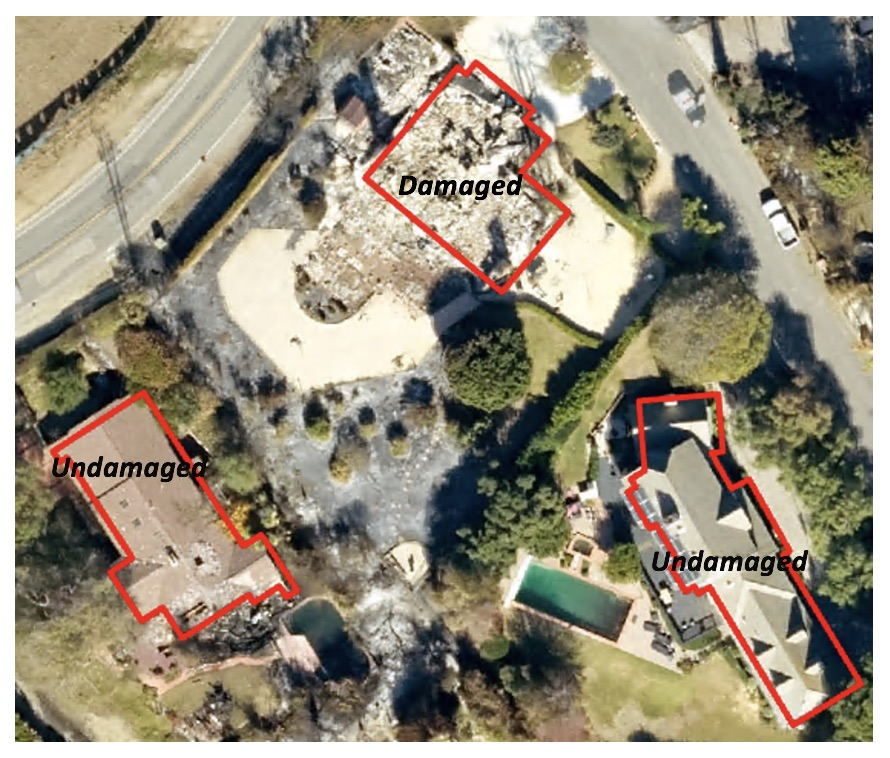
<center>Figure 1. Feature classification example </center>

### Methodology

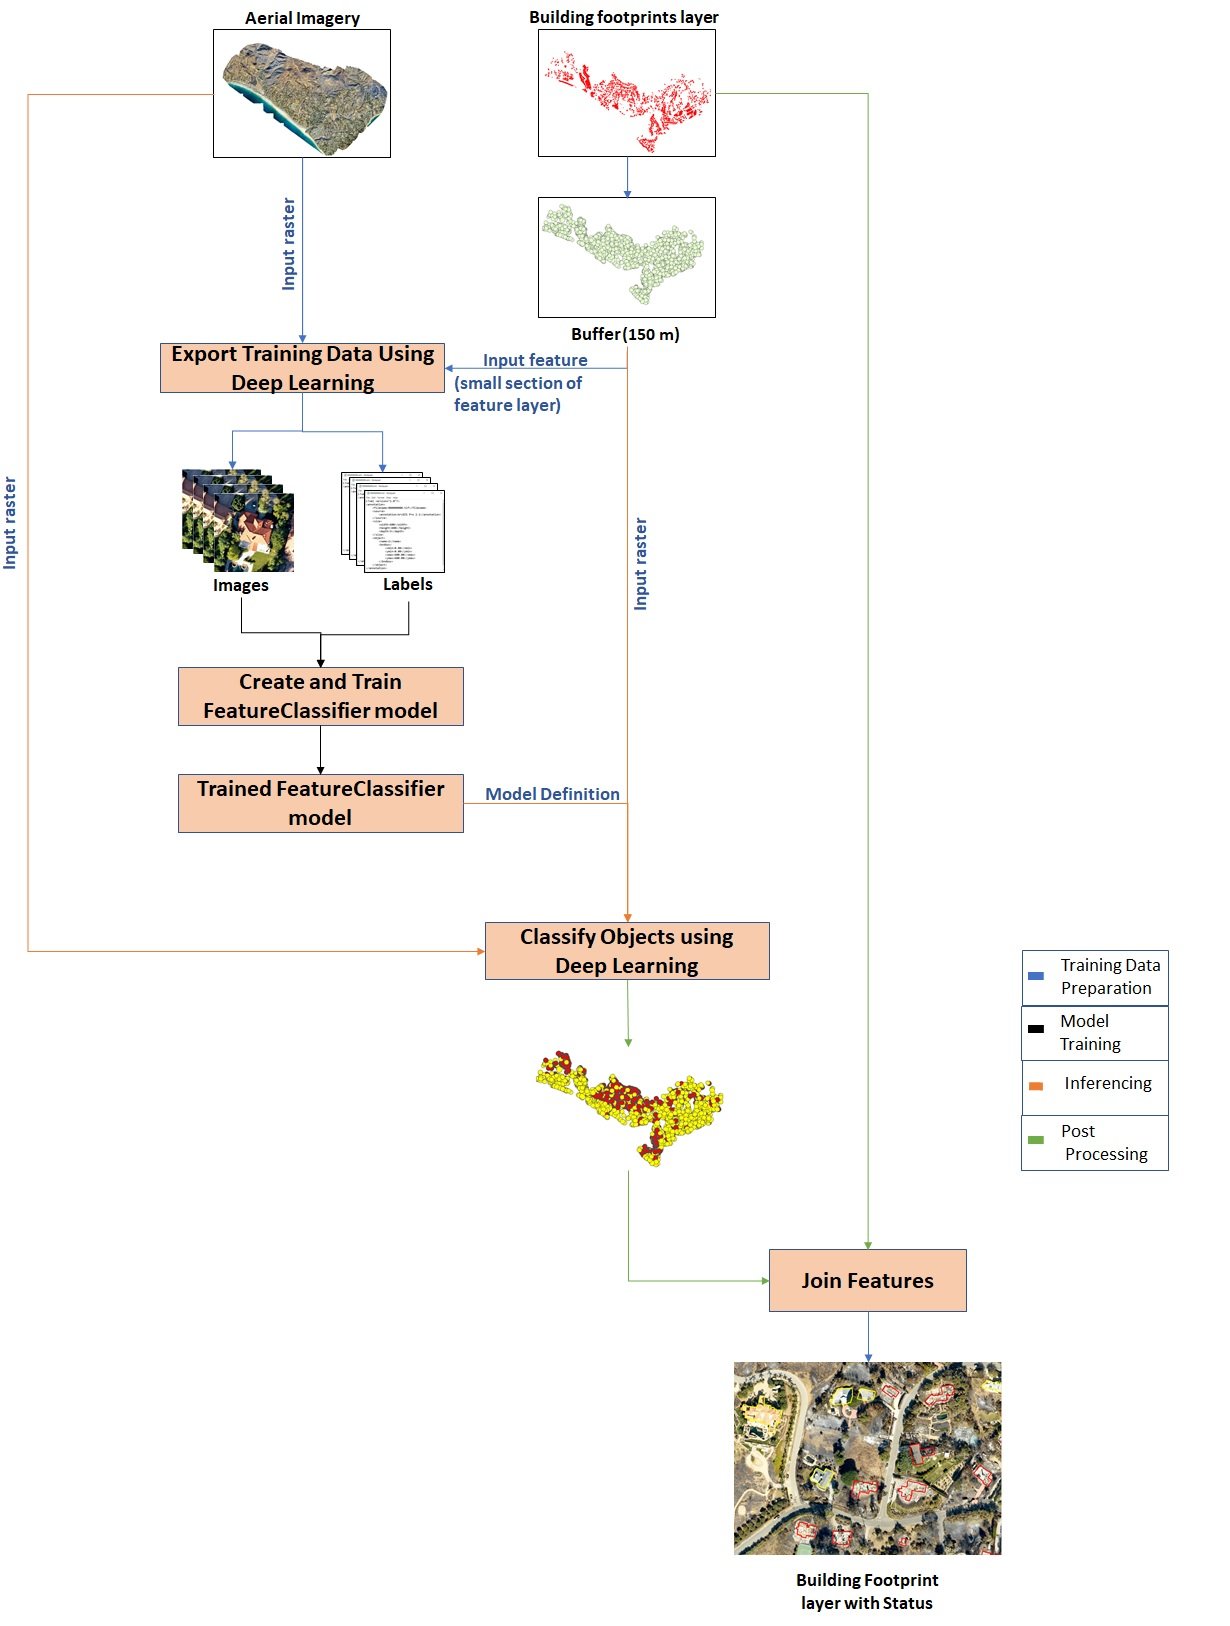<center>Figure 2. Methodology </center>

## Part 1 - Export training data for deep learning

To export training data for feature categorization, we need two input data:
- An input raster that contains the spectral bands,
- A feature class that defines the location (e.g. outline or bounding box) and label of each building.

### Import ArcGIS API for Python and get connected to your GIS

In [1]:
import os
from pathlib import Path

import arcgis
from arcgis import GIS
from arcgis import learn, create_buffers
from arcgis.raster import analytics, Raster
from arcgis.features.analysis import join_features
from arcgis.learn import prepare_data, FeatureClassifier, classify_objects,  Model, list_models
arcgis.env.verbose = True

In [2]:
gis = GIS('home')
gis_ent = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

### Prepare data that will be used for training data export

A building footprints feature layer will be used to define the location and label of each building.

<Item title:"buildings_woolsey" type:Feature Layer Collection owner:api_data_owner>
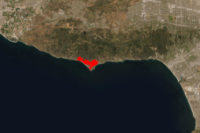

In [3]:
building_footprints = gis.content.search('buildings_woolsey', item_type='Feature Layer Collection')[0]
building_footprints

We will buffer the building footprints layer for 150m using [create_buffers](https://doc.arcgis.com/en/arcgis-online/analyze/create-buffers.htm) . With 150m buffer, when the training data will be exported it will cover the surrounding of houses which will help the model to understand the difference between damaged and undamaged houses.

In [45]:
building_buffer = arcgis.create_buffers(building_footprints, 
                                        distances=[150],
                                        units='Meters', 
                                        dissolve_type='None', 
                                        ring_type='Disks', 
                                        side_type='Full', 
                                        end_type='Round', 
                                        output_name='buildings_buffer'+str(datetime.now().microsecond), 
                                        gis=gis_ent)
building_buffer

<Item title:"buildings_buffer638853" type:Feature Layer Collection owner:api_data_owner>

In [46]:
building_buffer.share(everyone=True)

{'results': [{'itemId': '44f59ce43bdc43afb8bf8d085b2664f5',
   'success': True,
   'notSharedWith': []}]}

An aerial imagery of West Malibu will be used as input raster that contains the spectral bands. This raster will be used for exporting the training data.

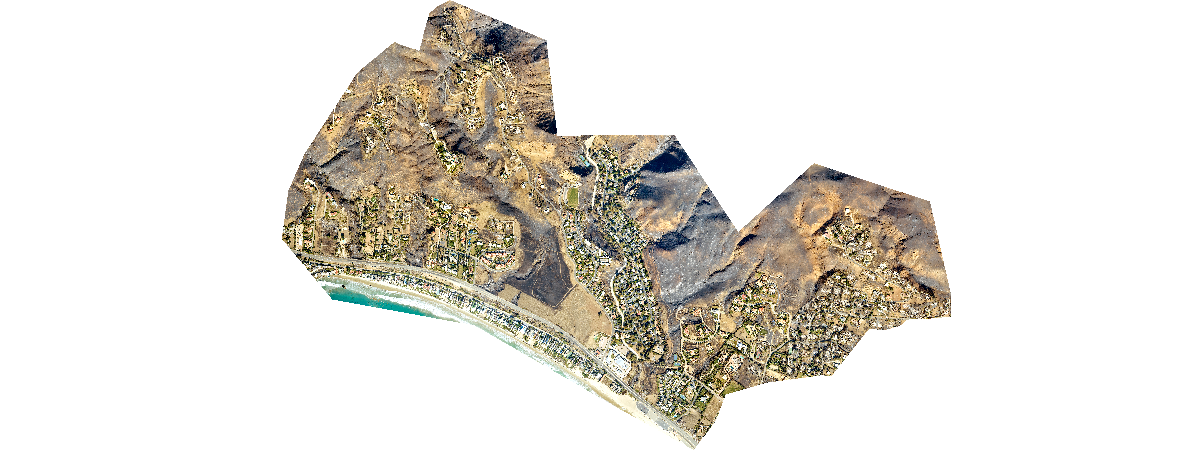

In [115]:
input_raster = Raster("https://pythonapi.playground.esri.com/ra/rest/services/Hosted/raster_for_training_damage_classifier/ImageServer",
                        gis=gis_ent,
                        engine="image_server")
input_raster

### Specify a folder name in raster store that will be used to store our training data

In [7]:
ds = analytics.get_datastores(gis=gis_ent)
ds

<DatastoreManager for https://pythonapi.playground.esri.com/ra/admin>

In [134]:
ds.search(types="rasterStore") 

[<Datastore title:"/rasterStores/RasterDataStore" type:"rasterStore">]

In [135]:
rasterstore = ds.get('/rasterStores/RasterDataStore')
rasterstore

<Datastore title:"/rasterStores/RasterDataStore" type:"rasterStore">

In [136]:
samplefolder = "feature_classifier_sample"+str(datetime.now().microsecond)
samplefolder

'feature_classifier_sample471203'

In [137]:
output_folder = rasterstore.datapath + "/" + samplefolder
output_folder

'/rasterStores/RasterDataStore/feature_classifier_sample471203'

### Export training data using `arcgis.learn`

Now ready to export training data using the `export_training_data()` method in arcgis.learn module. In addtion to feature class, raster layer, and output folder, we also need to specify a few other parameters such as `tile_size` (size of the image chips), `stride_size` (distance to move each time when creating the next image chip), `chip_format` (TIFF, PNG, or JPEG), `metadata_format` (how we are going to store those training labels). Note that unlike Unet and object detection, the metadata is set to be `Labeled_Tiles` here. More detail can be found [here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm). 

Depending on the size of your data, tile and stride size, and computing resources, this operation can take a while. In our experiments, this took 15mins~2hrs. Also, do not re-run it if you already run it once unless you would like to update the setting.

We will export the training data for a small sub-region of our study area and the whole study area will be used for inferencing of results. We will create a map widget, zoom in to the western corner of our study area and get the extent of the zoomed in map. We will use this extent in `Export training data using deep learning` function.

In [14]:
export = learn.export_training_data(input_raster=input_raster,
                                    output_location=output_folder,
                                    input_class_data=building_buffer.layers[0], 
                                    classvalue_field = "class_ecode",
                                    chip_format="TIFF", 
                                    tile_size={"x":600,"y":600}, 
                                    stride_size={"x":0,"y":0}, 
                                    metadata_format="Labeled_Tiles",                                        
                                    context={"startIndex": 0, "exportAllTiles": False, "cellSize": 0.1},
                                    gis = gis_ent)

## Part 2 - Model training

If you've already done part 1, you should already have the training chips. Please change the path to your own export training data folder that contains "images" and "labels" folder.

<Item title:"feature_categorization_using_satellite_imagery_and_deep_learning" type:Image Collection owner:api_data_owner>
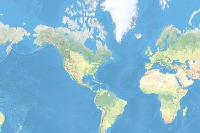

In [52]:
training_data = gis.content.get('14f3f9421c6b4aa3bf224479c0eaa4f9')
training_data

In [16]:
filepath = training_data.download(file_name=training_data.name)

In [17]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [18]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [19]:
data = prepare_data(data_path, {1:'Damaged', 2:'Undamaged'}, chip_size=600, batch_size=16)

### Visualize training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them.

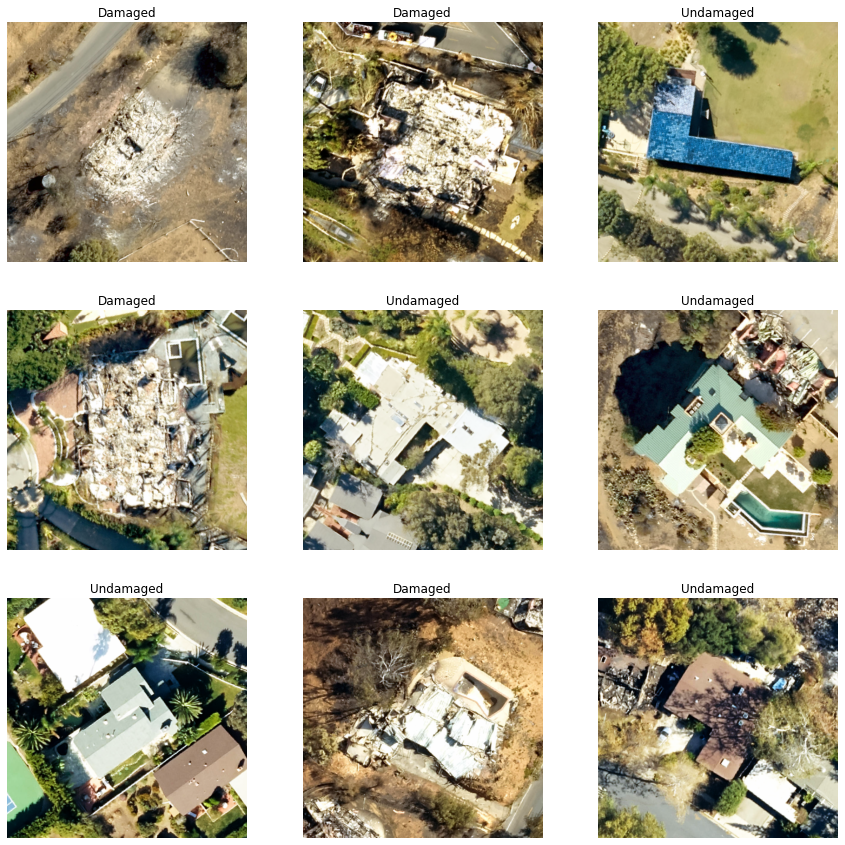

In [54]:
data.show_batch()

### Load model architecture

Now the building classification problem has become a standard image classfication problem. By default `arcgis.learn` uses Resnet34 as its backbone model followed by a softmax layer. 

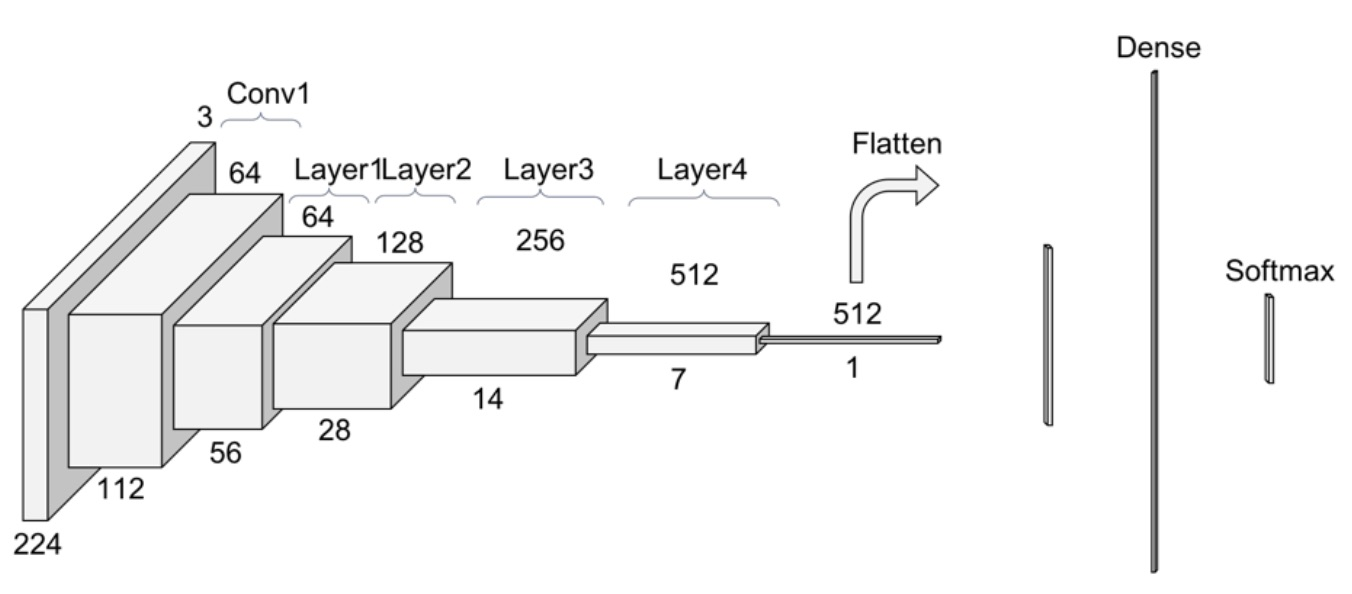
<center>Figure 2. Resnet34 architecture [1] </center>

In [21]:
model = FeatureClassifier(data)

### Train a model through learning rate tuning and transfer learning
[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. Here we explore a range of learning rates to guide us to choose the best one.

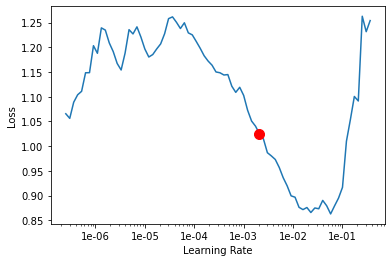

0.0020892961308540407

In [218]:
# The users can visualize the learning rate of the model with comparative loss. This case - loss rate decreases, so we are detecting more n more objects as it learns more
lr = model.lr_find()
lr

Based on the learning rate plot above, we can see that the loss going down most dramatically at 1e-2. Therefore, we set learning rate to be to 1e-2. Let's start with 10 epochs for the sake of time.

In [11]:
model.fit(epochs=15, lr=1e-2)

### Visualize classification results in validation set
Now we have the model, let's look at how the model performs.

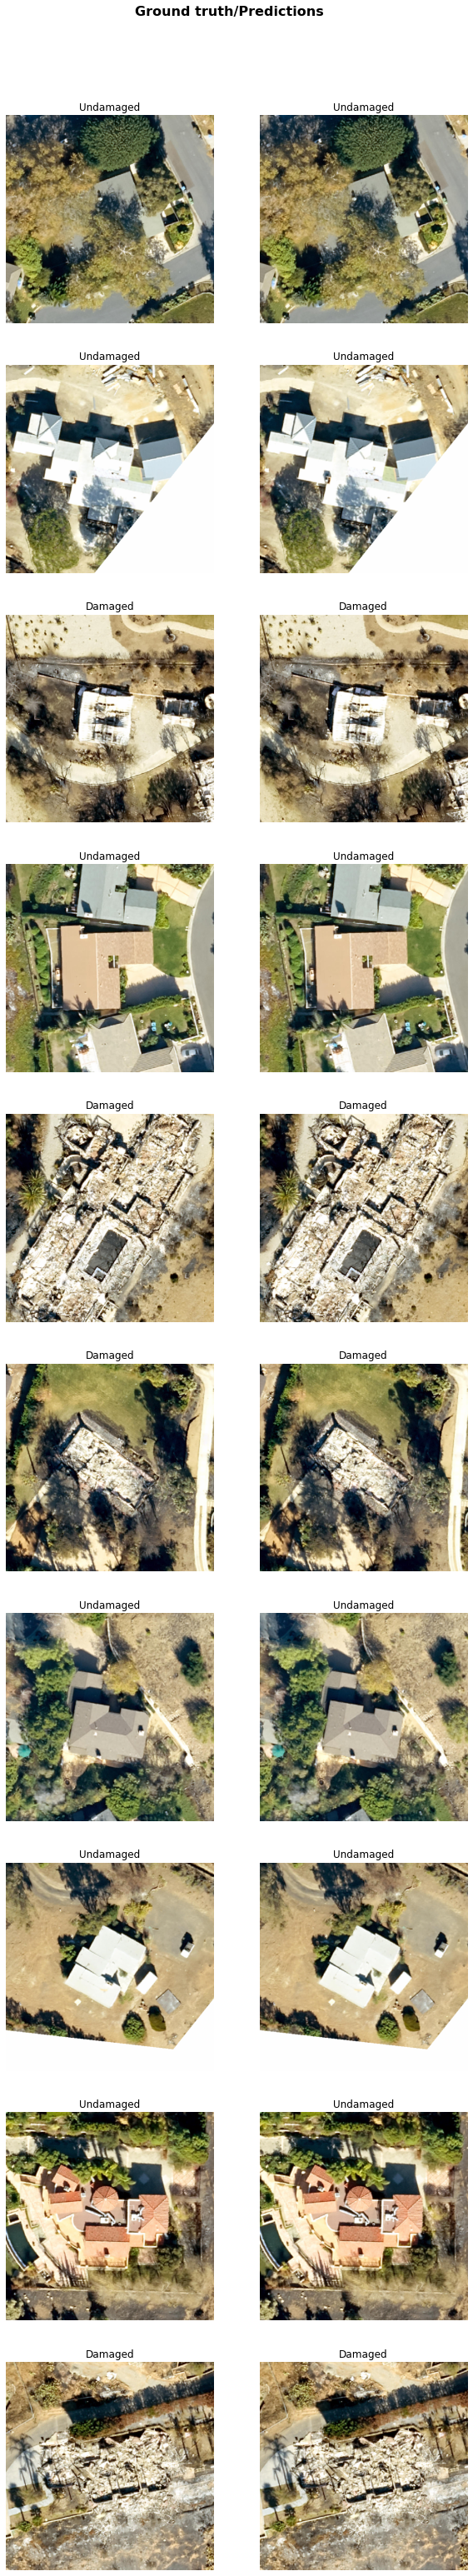

In [17]:
model.show_results(rows=10)

As we can see, with only 15 epochs, we are already seeing reasonable results. Further improvment can be acheived through more sophisticated hyperparameter tuning. Let's save the model for further training or inference later. The model should be saved into a models folder in your folder. By default, it will be saved into your `data_path` that you specified in the very beginning of this notebook.

In [23]:
model.save(r'damage_classifier_15e', publish=True, gis=gis_ent)

Published DLPK Item Id: 6a71b3fe09a84d02ba24f48319760564


WindowsPath('D:/data/damage_classifier_15e')

### Accuracy assessment

`arcgis.learn` provides the `plot_confusion_matrix()` function that plots a confusion matrix of the model predictions to evaluate the model's accuracy.

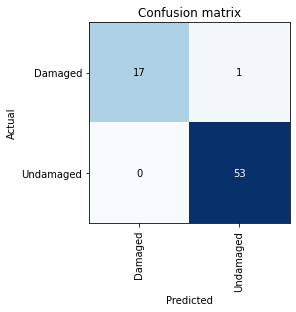

In [22]:
model.plot_confusion_matrix()

The confusion matrix validates that the trained model is learning to classify and differentiate between damaged and undamaged houses. The diagonal numbers show the number of scenes correctly classified as their respective categories

## Part 3 - Inference and post processing

Now we have the model ready, let's apply the model to a new feature class with a few new buildings and see how it performs.

In [29]:
fc_model_package = gis_ent.content.search("finetuned_damage_classifier_model owner:api_data_owner", item_type='Deep Learning Package')[0]
fc_model_package

<Item title:"finetuned_damage_classifier_model" type:Deep Learning Package owner:api_data_owner>

Now we are ready to install the model. Installation of the deep learning model item will unpack the model definition file, model file and the inference function script, and copy them to "trusted" location under the Raster Analytic Image Server site's system directory.

In [27]:
fc_model = Model(fc_model_package)

In [28]:
fc_model.install()

In [29]:
fc_model.query_info()

We will use [Classify Objects Using Deep Learning](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-objects-using-deep-learning.htm) for inferencing the results. The parameters required to run the function are:
- `in_raster`:The input raster dataset to classify. The input can be a single raster or multiple rasters in a mosaic dataset, an image service, or a folder of images.
- `out_feature_class`: The output feature class that will contain geometries surrounding the objects from the input feature class, as well as a field to store the classification label.
- `in_model_definition`: It contains the path to the deep learning binary model file, the path to the Python raster function to be used, and other parameters such as preferred tile size or padding.
- `in_features`: input feature class represents a single object. If no input feature class is specified, the tool assumes that each input image contains a single object to be classified.
- `class_label_field`: The name of the field that will contain the classification label in the output feature class. If no field name is specified, a new field called ClassLabel will be generated in the output feature class.

In [34]:
raster_for_inferencing = gis_ent.content.search('bc005b5349b6475aaf331d9f39e89466')[0]
raster_for_inferencing

<Item title:"damage_classifier_raster_for_inferencing" type:Imagery Layer owner:api_data_owner>

<Item title:"inferenced_layer_fc" type:Feature Layer Collection owner:api_data_owner>
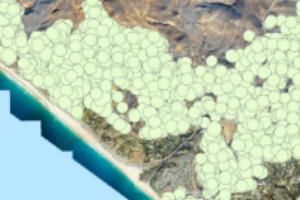

In [30]:
inferenced_lyr = classify_objects(input_raster=raster_for_inferencing,
                                  model = fc_model,
                                  model_arguments={'batch_size': 4}
                                  input_features=building_buffer.layers[0],
                                  output_name="inferenced_layer_fc"+str(datetime.now().microsecond),
                                  class_value_field='status',
                                  context={'cellSize': 0.5, 'processorType':'GPU'},
                                  gis=gis_ent)
inferenced_lyr

We can load the inference layer into a spatially enabled dataframe to examine the inference result. As we can see, all sample buildings are classified correctly with high confidence.

In [36]:
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor

sdf = pd.DataFrame.spatial.from_layer(inferenced_lyr.layers[0])
sdf[['objectid', 'type', 'status', 'confidence_classifyobjects']].head(10)

objectid       type     status  confidence_classifyobjects
0         1  Courtyard  Undamaged                    0.999948
1         2  Courtyard  Undamaged                    0.999177
2         3  Courtyard  Undamaged                    0.999988
3         4  Courtyard  Undamaged                    0.999957
4         5  Courtyard  Undamaged                    0.999875
5         6  Courtyard  Undamaged                    0.999691
6         7  Courtyard    Damaged                    0.990788
7         8  Courtyard  Undamaged                    0.954395
8         9  Courtyard  Undamaged                    0.999292
9        10  Courtyard  Undamaged                    0.999616

The next step is to join the `inferenced_lyr` with `building_footprints` so that the `building_footprints` layer will have the `status` column. We will use the output layer of [join features](https://pro.arcgis.com/en/pro-app/tool-reference/big-data-analytics/join-features.htm) function for visualization of results in map widget.

In [44]:
final_lyr = arcgis.features.analysis.join_features(building_footprints, 
                                                   inferenced_lyr, 
                                                   attribute_relationship=['{"targetField":"building_i","operator":"equal","joinField":"building_i"}'],
                                                   join_operation='JoinOneToOne',  
                                                   output_name='bfootprint_withstatus'+str(datetime.now().microsecond),  
                                                   gis=gis_ent)
final_lyr

<Item title:"bfootprint_withstatus990419" type:Feature Layer Collection owner:api_data_owner>

We can see the results in the webmap, click on the webmap a new tab will open which will show the classified building footprint layer overlayed on the aerial imagery. You can also add your inferenced layer to this webmap.

<Item title:"woolsey_building_damage" type:Web Map owner:api_data_owner>
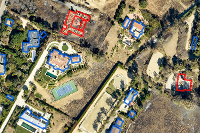

In [33]:
webmap = gis.content.search('woolsey_building_damage', outside_org=True)[0]
webmap

## Conclusion

In this notebook, we have covered a lot of ground. In part 1, we discussed how to export training data for deep learning using ArcGIS python API. In part 2, we demonstrated how to prepare the input data, train a feature classifier model, visualize the results, as well as apply the model to an unseen image. Then we covered how to installation of model, inferencing and post processing of inferenced results to make it production-ready in part 3. The same workflow can be applied to many other use cases. For example, when we know the locations of swimming pools, we can use it to indentify which ones are dirty and not being properly maintained.

## Reference

[1] Ruiz Pablo, Understanding and Visualizing ResNets,  https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8, Accessed 2 September 2019.